In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data and Policy

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/DrugSeries/expression.h5ad', backed=True)

# Model location and name
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251013', 800  # 32 dim - best for interp stages (USE)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110', 800  # 32 dim - sample normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-cont', 1600  # 32 dim - sample normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-log', 800  # 32 dim - sample and log normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251111-logclip', 800  # 32 dim - sample and log normalized, with clipping
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251113-pip', 800  # 32 dim - pipart fix

# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adata.obs['Training'] = mask

# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')

# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

# Run Untreated and Knockdown

In [4]:
# Parameters
print(adata.obs['treatment'].unique().to_numpy())
series = ['Untreated', 'DMSO', 'Tram']
timesteps = ['3hr', '6hr', '12hr', '24hr', '48hr']

['DMSO_48hr' 'Tram_24hr' 'DMSO_12hr' 'Tram_3hr' 'Tram_6hr' 'Tram_12hr'
 'Tram_48hr' 'Untreated_48hr' 'DMSO_3hr' 'DMSO_24hr' 'DMSO_6hr']


In [5]:
preprocess_common = lambda x: preprocessing.inverse_transform(preprocessing.transform([x]))[0]

In [6]:
adata.obs.groupby(['cell_line'], observed=True).size().reset_index().sort_values(0)

,cell_line,0
0,BILIARY_TRACT,222
9,PROSTATE,301
3,ENDOMETRIUM,614
11,STOMACH,665
8,OVARY,750
1,BREAST,752
13,URINARY_TRACT,936
12,UPPER_AERODIGESTIVE_TRACT,978
4,KIDNEY,999
5,LARGE_INTESTINE,1156


In [7]:
# Get untreated
common_mask = True
common_mask = adata.obs['cell_line'] == 'LUNG'
untreated_target = 'Untreated_48hr'
# untreated_target = 'DMSO_48hr'
# untreated_target = 'Tram_3hr'
untreated_idx = adata.obs_names[np.argwhere(common_mask * (adata.obs['treatment'] == untreated_target)).flatten()]
untreated_data = np.array(adata[untreated_idx].X.todense())
# untreated_data = preprocess_common(untreated_data)  # TESTING
untreated_pre, = preprocessing.transform([untreated_data])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(untreated_pre), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Compute steady state
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
untreated_steady_state_full = ret[-1][-1]
untreated_steady_state = untreated_steady_state_full[..., :env.dim]
with torch.no_grad(): untreated_gex = policy.pinning[0](untreated_steady_state.to('cuda')).detach().cpu().numpy()
untreated_gex, = preprocessing.inverse_transform(untreated_gex, subset_modality=0)

6400it [00:18, 346.53it/s]


In [8]:
# Compute knockdown
skip_states = 32
sim_time = 128.
# adata.var.loc[adata.var['gene_name'] == 'NF1']
# (adata.var['gene_name'].str.contains('RAF1')).sum()
gene_names = ['MAP2K1', 'MAP2K2']  # 'BRAF', 'NRAS', 'KRAS', 'RAF1', 'NF1'
knocked_target = 'Tram_3hr'
# knocked_target = 'Tram_48hr'

# Get feature targets
gene_idx = adata.var_names[adata.var['gene_name'].isin(gene_names)].to_numpy().astype(int)
knocked_data = np.array(adata[np.argwhere(common_mask * (adata.obs['treatment'] == knocked_target)).flatten()].X.todense())
# knocked_data = preprocess_common(knocked_data)  # TESTING
mean_un = untreated_data[:, gene_idx].mean(keepdims=True, axis=0)
mean_ko = knocked_data[:, gene_idx].mean(keepdims=True, axis=0)
std_un = untreated_data[:, gene_idx].std(keepdims=True, axis=0)
std_ko = knocked_data[:, gene_idx].std(keepdims=True, axis=0)
# feature_targets = np.zeros((1, len(gene_idx)))
feature_targets = knocked_data[:, gene_idx].mean(axis=0)
# feature_targets = np.expand_dims(feature_targets, 0).repeat(944, 0).shape
# feature_targets = np.clip((untreated_data[:, gene_idx] - mean_un) / std_un * std_ko + mean_ko, 0, None)  # Distribution matching

# CLI
mean_un = untreated_data[:, gene_idx].mean()
mean_knock = (knocked_data[:, gene_idx] - untreated_data[:, gene_idx].mean(axis=0)).mean()
print(f'Observed a mean difference under knockdown of {mean_knock:.2f} from a mean of {mean_un:.2f}')

# Perform simulation
# Set steady state and time
env.reset().set_max_time(sim_time)
env.set_state(untreated_steady_state_full.to('cuda'))
# DMSO
# dmso_data = np.array(adata[np.argwhere(adata.obs['treatment'] == 'DMSO_48hr').flatten()].X.todense())
# dmso_data = preprocess_common(dmso_data)  # TESTING
# # dmso_offset = dmso_data.mean(keepdims=True, axis=0) - untreated_data.mean(keepdims=True, axis=0)
# dmso_offset = preprocessing.transform([dmso_data])[0].mean(keepdims=True, axis=0) - preprocessing.transform([untreated_data])[0].mean(keepdims=True, axis=0)
# env.modality_offsets[0] += torch.tensor(dmso_offset).to('cuda')
# Run
ret = celltrip.train.simulate_until_completion(
    env, policy,
    env_hooks=[
        celltrip.utility.hooks.clamp_input_features_hook(
            gene_idx, preprocessing, feature_targets=0., modality_idx=0,
            device='cuda'),
        # celltrip.utility.hooks.clamp_inverted_features_hook(
        #     gene_idx, preprocessing, feature_targets=feature_targets, modality_idx=0),
    ],
    action_hooks=[
        celltrip.utility.hooks.move_toward_targets_hook(
            gene_idx, feature_targets=feature_targets, pinning=policy.pinning[0],
            preprocessing=preprocessing, modality_idx=0,
            factor=1., device=env.device)
    ],
    skip_states=skip_states, store_states='cpu', progress_bar=True)
knocked_timeseries = ret[-1][..., :env.dim]
with torch.no_grad(): knocked_gex = policy.pinning[0](knocked_timeseries.to('cuda')).detach().cpu().numpy()
knocked_gex, = preprocessing.inverse_transform(knocked_gex, subset_modality=0)


Observed a mean difference under knockdown of 0.26 from a mean of 4.28


1280it [00:06, 190.74it/s]


In [9]:
# (dmso_data.mean(axis=0) - untreated_data.mean(axis=0)).mean()

## Visualize

In [10]:
# Calculate pdelta results
# eps = 30  # Minimum var difference for which we should compute correlation
all_treatments = [f'Tram_{t}' for t in timesteps]  # [1:]
pdelta_results = pd.DataFrame(index=all_treatments, columns=skip_states*np.arange(knocked_timeseries.shape[0]), dtype=float)
pert_diffs = []
for treatment in pdelta_results.index:
    # Get actual perturbation delta
    pert_idx = adata.obs_names[np.argwhere(common_mask * (adata.obs['treatment'] == treatment)).flatten()]
    pert_data = np.array(adata[pert_idx].X.todense())
    pert_diff = pert_data.mean(axis=-2) - untreated_data.mean(axis=-2)
    pert_diffs.append(pert_diff)

    # Get predicted perturbation delta
    pred_diff = knocked_gex.mean(axis=-2) - np.expand_dims(untreated_gex, axis=0).mean(axis=-2)
    # pred_diff = knocked_gex.mean(axis=-2) - knocked_gex[[5]].mean(axis=-2)
    # pred_diff_nan_mask = np.abs(pred_diff).mean(axis=-1) < eps
    # pred_diff_nan_mask = pred_diff.var(axis=-1) < eps

    # Calculate pearson delta for prediction
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)[0, 1:]  # Not optimal
    # pdelta = -np.square(np.expand_dims(pert_diff, axis=0) - pred_diff).mean(axis=-1)  # MSE
    pdelta_results.loc[treatment] = pdelta
    # pdelta_results.loc[treatment, pred_diff_nan_mask] = np.nan  # Mask out unreliably low perturbations

    # Calculate pearson delta for actual
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)

# Crop first and last timestep - same as untreated and uneven step, respectively
pdelta_results = pdelta_results.iloc[:, 1:-1]

# Get pearson delta for actual
pert_diffs = np.stack(pert_diffs, axis=0)
pdelta = np.corrcoef(pert_diffs)
pdelta_actual = pd.DataFrame(pdelta, index=all_treatments, columns=all_treatments, dtype=float)

# Normalize
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().mean(keepdims=True, axis=1)) / pdelta_results.to_numpy().std(keepdims=True, axis=1)
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().mean(keepdims=True, axis=1)) / pdelta_actual.to_numpy().nanstd(keepdims=True, axis=1)
pdelta_results_norm = (pdelta_results - np.nanmean(pdelta_results.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_results.to_numpy(), keepdims=True, axis=1)
pdelta_actual_norm = (pdelta_actual - np.nanmean(pdelta_actual.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_actual.to_numpy(), keepdims=True, axis=1)
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))

Using Kernel Size 4
Using Kernel Size 4
Using Kernel Size 4
Using Kernel Size 4


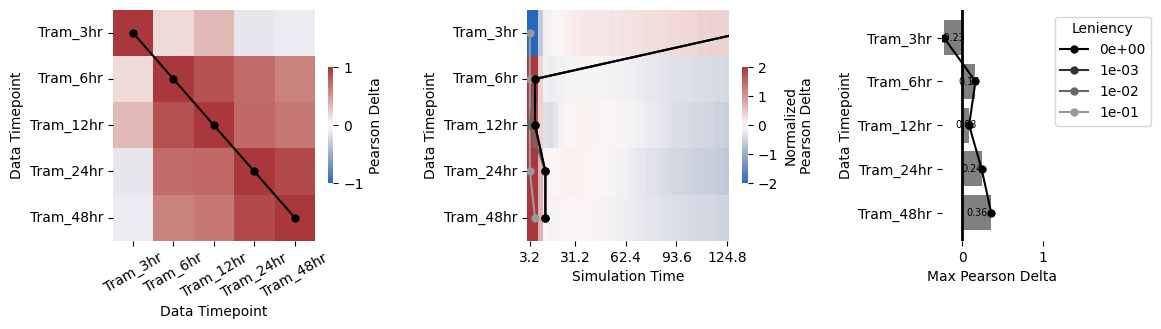

In [11]:
# Create figure
widths = [5, 5, 2]
line_kwargs = dict(marker='o', markersize=6, markeredgecolor='none')
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=.8)

# Annotate max
num_lines = 4
eps_list = np.concat([np.logspace(-1, -3, num_lines-1, base=10), [0]])
white_list = np.linspace(.6, 0., num_lines)
def get_peak(df, kernel_size=None, eps=1e-2):
    # Default params
    if kernel_size is None:
        kernel_size = np.ceil((10/sim_time)*df.shape[1]).astype(int)
        print(f'Using Kernel Size {kernel_size}')
    # Moving window
    smoothed = np.stack([
        np.convolve(df.to_numpy()[i], np.ones(kernel_size) / kernel_size, mode='full')
        for i in range(df.shape[0])], axis=0)
    return (smoothed >= smoothed.max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # return smoothed.argmax(axis=1)
    # Weighted mean
    # data = df.to_numpy()
    # data = (data - data.min(keepdims=True, axis=1)) / data.std(keepdims=True, axis=1)  # / (data.max(keepdims=True, axis=1) - data.min(keepdims=True, axis=1))
    # data = np.exp(data)  # Scaling exp
    # data = data / data.sum(keepdims=True, axis=1)
    # return (data * np.expand_dims(np.arange(data.shape[1]), axis=0)).sum(axis=1)
    # First to max-eps
    # return (df.to_numpy() >= df.to_numpy().max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # Max
    # return df.to_numpy().argmax(axis=1)

# Reference pdelta heatmap
ax = axs[0]
sns.heatmap(
    pdelta_actual,
    cmap='vlag', vmin=-1, vmax=1,
    cbar_kws={
        'shrink': .5, 'ticks': np.arange(-1, 1.01, 1.),
        'label': 'Pearson Delta'}, ax=ax)
ax.set(xlabel='Data Timepoint', ylabel='Data Timepoint')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# Annotate max
ax.plot(
    get_peak(pdelta_actual, kernel_size=1, eps=0) + .5,
    np.arange(pdelta_actual.shape[0]) + .5,
    color='black', **line_kwargs)

# Actual pdelta heatmap
ax = axs[1]
df_use = pdelta_results_norm
# df_use = pdelta_results
sns.heatmap(
    df_use,
    cmap='vlag',
    vmin=-2, vmax=2,
    cbar_kws={
        'shrink': .5,
        'ticks': np.arange(-2, 2.01, 1.),
        'label': 'Normalized\nPearson Delta'}, ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Data Timepoint')
xtick_step = df_use.shape[1] / 4
xticks = np.array([1] + np.arange(
    xtick_step, xtick_step*(1+df_use.shape[1]//xtick_step), xtick_step).tolist()) - .5
xticklabels = skip_states * env.delta * (xticks + .5)
xticklabels = [f'{l:.1f}' for l in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)
# Annotate max
for eps, white in zip(eps_list, white_list):
    ax.plot(
        get_peak(pdelta_results, eps=eps) + .5,
        np.arange(pdelta_results.shape[0]) + .5,
        color=3*[white], **line_kwargs)

# Peak performance
ax = axs[2]
pdelta_results_max = pdelta_results.max(axis=1).reset_index()
pdelta_results_max.columns = ['Data Timepoint', 'Max Pearson Delta']
bar = sns.barplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='gray', ax=ax)
sns.lineplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='black', **line_kwargs, ax=ax)
ax.bar_label(bar.containers[0], fmt='{:0.2f}', label_type='center', fontsize='x-small')
# ax.set(ylabel=None, yticklabels=[], yticks=[])
ax.set_xlim(right=1.)
# ax.tick_params(axis='x', which='major', length=0)
ax.axvline(x=0, color='black', lw=2)
sns.despine(left=True, bottom=True)

# Make legend
ax.legend(handles=[
    mpl.lines.Line2D([], [], color=3*[white], **line_kwargs, label=f'{eps:.0e}')
    for eps, white in zip(eps_list, white_list)][::-1],
    loc='upper left', bbox_to_anchor=(1.05, 1.), title='Leniency')

fig.savefig('../plots/drugseries/Timed_Pearson_Delta.pdf')

In [12]:
pdelta_results

,32,64,96,128,160,192,224,256,288,320,...,960,992,1024,1056,1088,1120,1152,1184,1216,1248
Tram_3hr,-0.511341,-0.406104,-0.278476,-0.255304,-0.253345,-0.249105,-0.245451,-0.242835,-0.240162,-0.238002,...,-0.230268,-0.229671,-0.229150,-0.228898,-0.227282,-0.227497,-0.226161,-0.226892,-0.226109,-0.226686
Tram_6hr,0.163966,0.050749,-0.021961,-0.042738,-0.044524,-0.044085,-0.042125,-0.040866,-0.040355,-0.040249,...,-0.048965,-0.049281,-0.049447,-0.050306,-0.050357,-0.050813,-0.051035,-0.051754,-0.051804,-0.052737
Tram_12hr,0.084960,0.004085,-0.025662,-0.040861,-0.042096,-0.040256,-0.037045,-0.035042,-0.033609,-0.033034,...,-0.042166,-0.042594,-0.042744,-0.043653,-0.043337,-0.044065,-0.044167,-0.045232,-0.044930,-0.045851
Tram_24hr,0.240610,0.142351,0.089552,0.069005,0.067188,0.067636,0.069248,0.069719,0.070102,0.069492,...,0.051861,0.051243,0.050718,0.049895,0.050000,0.049049,0.048747,0.047767,0.047601,0.046622
Tram_48hr,0.359818,0.262917,0.181150,0.152233,0.148045,0.147937,0.149661,0.150181,0.150478,0.149933,...,0.137600,0.136918,0.136371,0.135768,0.135469,0.134799,0.134164,0.133569,0.133152,0.132537


In [13]:
adata.obs.loc[adata.obs['treatment'].str.startswith('Tram')]

,barcode,singlet_ID,num_SNPs,singlet_dev,singlet_dev_z,singlet_margin,singlet_z_margin,doublet_z_margin,tot_reads,doublet_dev_imp,...,doublet_GMM_prob,hash_assignment,treatment,channel,DepMap_ID,cell_line,Drug,Timestep,train,Training
1,AAACCCAAGCATACTC-1_chA,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,3202,0.676883,19.033511,0.521603,18.471608,0.065873,7620,0.004070,...,3.349745e-04,Tram_24hr,Tram_24hr,A,ACH-000329,CENTRAL_NERVOUS_SYSTEM,Tram,24hr,False,False
6,AAACCCACACAATCTG-1_chA,SH10TC_STOMACH,1926,0.719157,9.815030,0.485037,8.287331,0.220898,3854,0.005806,...,1.891487e-03,Tram_24hr,Tram_24hr,A,ACH-000764,STOMACH,Tram,24hr,False,False
11,AAACCCAGTGCGAACA-1_chA,CCFSTTG1_CENTRAL_NERVOUS_SYSTEM,1309,0.605021,20.084447,0.455995,18.754857,0.110101,2104,0.004075,...,4.246668e-04,Tram_3hr,Tram_3hr,A,ACH-000329,CENTRAL_NERVOUS_SYSTEM,Tram,3hr,True,True
13,AAACCCATCCTACACC-1_chA,DKMG_CENTRAL_NERVOUS_SYSTEM,1260,0.612749,21.265368,0.472980,20.367114,0.066817,2042,0.003960,...,3.569960e-04,Tram_6hr,Tram_6hr,A,ACH-000244,CENTRAL_NERVOUS_SYSTEM,Tram,6hr,True,True
17,AAACGAAAGCCTGCCA-1_chA,DKMG_CENTRAL_NERVOUS_SYSTEM,768,0.596667,18.362686,0.421696,16.567924,0.481747,1112,0.005311,...,1.209920e-03,Tram_6hr,Tram_6hr,A,ACH-000244,CENTRAL_NERVOUS_SYSTEM,Tram,6hr,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,TTTGACTTCGTAGTCA-1_chB,UMUC1_URINARY_TRACT,1250,0.565618,12.532283,0.378737,9.862794,1.958016,2299,0.010323,...,1.440047e-04,Tram_6hr,Tram_6hr,B,ACH-000834,URINARY_TRACT,Tram,6hr,True,True
20003,TTTGGAGAGCCTTCTC-1_chB,COLO680N_OESOPHAGUS,746,0.686053,17.209350,0.494029,14.283399,2.536202,1227,0.002081,...,2.166562e-10,Tram_24hr,Tram_24hr,B,ACH-000717,OESOPHAGUS,Tram,24hr,False,False
20007,TTTGGAGGTGCAATGG-1_chB,RCC10RGB_KIDNEY,416,0.677504,9.916886,0.461943,8.321589,0.577903,654,0.004408,...,6.933964e-08,Tram_48hr,Tram_48hr,B,ACH-000189,KIDNEY,Tram,48hr,True,True
20011,TTTGGAGTCGTGCAGC-1_chB,SQ1_LUNG,701,0.765257,11.284003,0.529281,9.417773,0.447277,1004,0.004944,...,2.892760e-07,Tram_6hr,Tram_6hr,B,ACH-000553,LUNG,Tram,6hr,True,True


In [14]:
# assert False

# Run Interpolation on 24hr

In [15]:
# Load sample-normalized model
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110', 700  # 32 dim - sample-normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-cont', 1600  # 32 dim - sample-normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-log', 800  # 32 dim - sample and log normalized (USE)
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

In [16]:
# adata.obs.groupby('cell_line').size()

In [20]:
# Determine stages to interpolate
drug, start_time, interp_time, end_time = 'Tram', '12hr', '24hr', '48hr'
start_stage, interp_stage, end_stage = f'{drug}_{start_time}', f'{drug}_{interp_time}', f'{drug}_{end_time}'

# Get known data
# common_mask = True
common_mask = adata.obs['cell_line'] == 'LUNG'
start_exp = np.array(adata[common_mask * (adata.obs['treatment']==start_stage)].X.todense())
interp_exp = np.array(adata[common_mask * (adata.obs['treatment']==interp_stage)].X.todense())
end_exp = np.array(adata[common_mask * (adata.obs['treatment']==end_stage)].X.todense())

# Use K-Means to create start and end pseudocells
start_n_pcells = end_n_pcells = min([exp.shape[0] for exp in (start_exp, interp_exp, end_exp)])  # 500
start_pcell_ids = sklearn.cluster.KMeans(n_clusters=start_n_pcells, random_state=42).fit_predict(start_exp)
end_pcell_ids = sklearn.cluster.KMeans(n_clusters=end_n_pcells, random_state=42).fit_predict(end_exp)
print(f'Chose {start_n_pcells}-{end_n_pcells} cells')

# Get expression and spatial for pseudocells
start_processed_exp = np.stack([start_exp[np.argwhere(start_pcell_ids==i).flatten()].mean(axis=0) for i in range(start_n_pcells)], axis=0)
end_processed_exp = np.stack([end_exp[np.argwhere(end_pcell_ids==i).flatten()].mean(axis=0) for i in range(end_n_pcells)], axis=0)

# Calculate OT matrix
a, b, _, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(start_processed_exp, end_processed_exp)

# Calculate pseudocells
pcells = [([i], np.argwhere(OT_mat[i] > 0).flatten()) for i in range(OT_mat.shape[0]) if OT_mat[i].sum() > 0]
start_pcells_exp, end_pcells_exp = [], []
start_pcells_obs, end_pcells_obs = [], []
for pcell_start, pcell_end in pcells:
    start_pcells_exp.append(start_processed_exp[pcell_start].mean(axis=0))
    end_pcells_exp.append(end_processed_exp[pcell_end].mean(axis=0))
start_pcells_exp = np.stack(start_pcells_exp, axis=0)
end_pcells_exp = np.stack(end_pcells_exp, axis=0)

# Run to initial steady state
start_m1, = preprocessing.transform([start_pcells_exp])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(start_m1), compute_rewards=False, dim=env.dim).eval(time_scale=5).to('cuda')
env.reset()
celltrip.train.simulate_until_completion(env, policy, store_states=False, progress_bar=True)

# Get transition states
end_m1, = preprocessing.transform([end_pcells_exp])
env.set_modalities([torch.tensor(end_m1)]).set_max_time(64.).to('cuda')
env.time = 0  # Reset timing
transition_skip = 20
transition_states = celltrip.train.simulate_until_completion(env, policy, skip_states=transition_skip, store_states='cpu', progress_bar=True)[-1][..., :env.dim].cpu()
num_even_states = env.max_time / (transition_skip * env.delta)
transition_sim_time = (transition_skip * env.delta * np.arange(num_even_states+1)).tolist()
if num_even_states != int(num_even_states): transition_sim_time += [env.max_time]
transition_sim_time = np.array(transition_sim_time)

# Impute
with torch.no_grad(): transition_states_exp = policy.pinning[0](transition_states.to('cuda')).detach().cpu().numpy()
transition_states_exp, = preprocessing.inverse_transform(transition_states_exp, subset_modality=0)


Chose 144-144 cells


6400it [00:18, 349.14it/s]
640it [00:01, 357.77it/s]


Distance by Timepoint: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


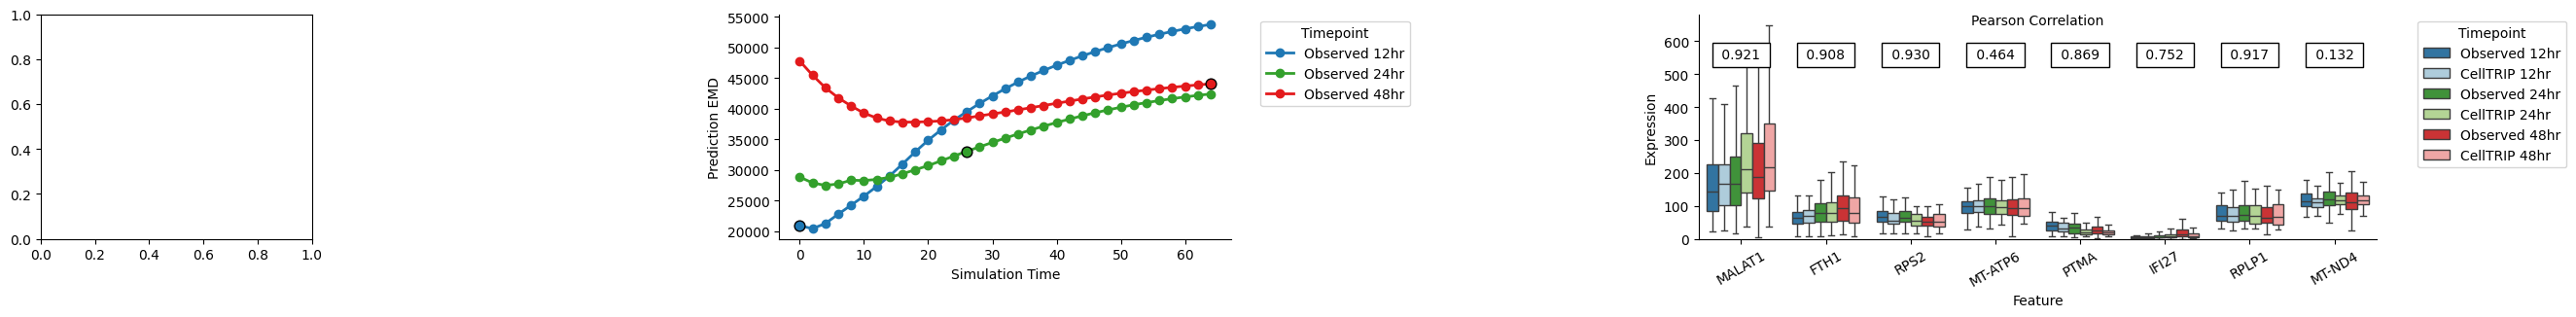

In [21]:
# Generate figure
widths = [6, 10, 15]
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=1.)
# Result tuples
preprocess_common = lambda x: preprocessing.inverse_transform(preprocessing.transform([x]))[0]
normalize_counts = lambda x: 10_000 * x / x.sum(keepdims=True, axis=-1)
preprocess_normalize = lambda x: normalize_counts(preprocess_common(x))
point_tuples = [
    # ('Observed 12hr', start_exp),
    # ('Observed 24hr', interp_exp),
    # ('Observed 48hr', end_exp)]
    ('Observed 12hr', preprocess_common(start_exp)),
    ('Observed 24hr', preprocess_common(interp_exp)),
    ('Observed 48hr', preprocess_common(end_exp))]
    # ('Observed 12hr', preprocessing.transform([start_exp])[0]),
    # ('Observed 24hr', preprocessing.transform([interp_exp])[0]),
    # ('Observed 48hr', preprocessing.transform([end_exp])[0])]
celltrip_transition_idx = 13  # 3
celltrip_tuples = [
    ('CellTRIP 12hr', transition_states_exp[0]),
    ('CellTRIP 24hr', transition_states_exp[celltrip_transition_idx]),
    ('CellTRIP 48hr', transition_states_exp[-1])]
    # ('CellTRIP 12hr', preprocess_common(transition_states_exp[0])),
    # ('CellTRIP 24hr', preprocess_common(transition_states_exp[3])),
    # ('CellTRIP 48hr', preprocess_common(transition_states_exp[-1]))]
    # ('CellTRIP 12hr', preprocessing.transform([transition_states_exp[0]])[0]),
    # ('CellTRIP 24hr', preprocessing.transform([transition_states_exp[3]])[0]),
    # ('CellTRIP 48hr', preprocessing.transform([transition_states_exp[-1]])[0])]
# Combine tuples
all_tuples = point_tuples + celltrip_tuples
all_tuples = list(all_tuples[::3]) + list(all_tuples[1::3]) + list(all_tuples[2::3])
# Paired colors
all_colors = sns.color_palette('Paired', 6)
colors = list(all_colors[1::2]) + list(all_colors[::2])
all_colors = list(colors[::3]) + list(colors[1::3]) + list(colors[2::3])

# UMAP
# ax = axs[0]
# reduction = umap.UMAP(n_neighbors=200, random_state=42).fit(np.concat(list(map(lambda t: t[1], point_tuples)), axis=0))
# for (name, points), color in tqdm.tqdm(zip(all_tuples, all_colors), desc='UMAP Transform', total=len(all_tuples)):
#     ax.scatter(*reduction.transform(points).T, s=5., color=color, label=name)
# ax.set_aspect('equal')
# sns.despine(ax=ax)
# ax.set(xlabel='UMAP-1', ylabel='UMAP-2')
# ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Distance by timepoint
ax = axs[1]
for i, (name, points) in tqdm.tqdm(enumerate(point_tuples), desc='Distance by Timepoint', total=len(point_tuples)):
    # Get error
    # err = np.square(transition_states_exp - np.expand_dims(points, axis=0)).mean(axis=(-2, -1))
    emd = np.array([celltrip.utility.distance.compute_emd(tse, points) for tse in transition_states_exp])  # EMD
    mse = np.square(transition_states_exp.mean(axis=1) - points.mean(keepdims=True, axis=0)).mean(axis=-1)  # MSE
    # err = np.array([
    #     celltrip.utility.distance.compute_emd(tse, preprocessing.transform([points])[0])
    #     for tse in preprocessing.transform([
    #         transition_states_exp.reshape([-1, transition_states_exp.shape[-1]])])[0].reshape([
    #             *transition_states_exp.shape[:2], -1])])
    # Plot
    ax.plot(transition_sim_time, emd, color=colors[i], lw=2, marker='o', markersize=6, label=f'{name}')
    # ax.plot(transition_sim_time, mse, color=colors[i], lw=2, ls='--', markersize=6, label=f'{name} - MSE')
    if name == 'Observed 12hr':
        ax.scatter(transition_sim_time[[0]], emd[[0]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 24hr':
        # expected_idx = emd.argmin()  # min_idx
        expected_idx = celltrip_transition_idx
        ax.scatter(transition_sim_time[[expected_idx]], emd[[expected_idx]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 48hr':
        ax.scatter(transition_sim_time[[-1]], emd[[-1]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
# Format
sns.despine(ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Prediction EMD')
ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Sample gene distances
ax = axs[2]
interp_distribution = []
# Choose genes
assert preprocessing.filter_mask[0] is None
# chosen_gene_idx = np.random.choice(start_exp.shape[1], 8)  # Random
# chosen_gene_idx = preprocessing.standardize_std[0].argsort()[::-1].flatten()[:8]  # Top variant
# chosen_gene_idx = np.abs(end_exp.mean(axis=0) - start_exp.mean(axis=0)).argsort()[::-1][:8]  # Top varying by mean across stages
chosen_gene_idx = np.abs(np.median(end_exp, axis=0) - np.median(start_exp, axis=0)).argsort()[::-1][:8]  # Top varying by median across stages
chosen_genes = adata.var.loc[adata.var_names[chosen_gene_idx], 'gene_name'].tolist()
for name, points in all_tuples:
    df = pd.DataFrame(points[:, chosen_gene_idx], columns=chosen_genes)
    df['Timepoint'] = name
    interp_distribution.append(df)
# Format df
interp_distribution = (
    pd.concat(interp_distribution, axis=0)
    .melt(id_vars='Timepoint', var_name='Feature', value_name='Expression'))
# Plot
box = sns.boxplot(
    interp_distribution, x='Feature', y='Expression', hue='Timepoint',
    hue_order=list(map(lambda a: a[0], all_tuples)), palette=all_colors,
    showfliers=False, ax=ax)
# Compute correlation for each gene
gene_corr = {}
for gene in chosen_genes:
    timepoint_expression = interp_distribution.loc[interp_distribution['Feature'] == gene]
    # timepoint_expression = timepoint_expression.groupby('Timepoint')['Expression'].mean()  # Use means
    timepoint_expression = timepoint_expression.groupby('Timepoint')['Expression'].median()  # Use medians
    # Relies on sorting of input tuples
    gene_corr[gene] = scipy.stats.pearsonr(
        timepoint_expression.loc[timepoint_expression.index.str.startswith('Observed')],
        timepoint_expression.loc[timepoint_expression.index.str.startswith('CellTRIP')],
        alternative='greater')
# Annotate
ax.text(
    .5, 1., f'Pearson Correlation', ha='center', va='top', transform=ax.transAxes)
for i, gene in enumerate(chosen_genes):
    corr, p = gene_corr[gene].statistic, gene_corr[gene].pvalue
    corr_str = f'{gene_corr[gene].statistic: >6.3f}'
    corr_str += '*' if p < .05 else ' '
    ax.text(
        i, .85, corr_str, ha='center', va='top',
        bbox=dict(facecolor='white', edgecolor='black'),
        transform=mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes))
# Format
# ax.set_ylabel('Count-Normalized Expression')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(ax=ax)
sns.move_legend(box, loc='upper left', bbox_to_anchor=(1.05, 1.))
ax.set_ylim(bottom=0)

fig.savefig('../plots/drugseries/Interpolation_Performance.pdf')
